In [ ]:
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.vec_env import DummyVecEnv
import gym
from MetaWorld.searchTest.utils import MyEnv, ToyExpertModel, sample_expert_transitions, benchmark_policy, LearnWrapper, train_policy, SuperMyGymWrapper, supermipWrapper, LearnWrapper
import torch
import zipfile
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
import importlib
import numpy as np
from RlBaselines3Zoo import enjoy
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.ppo import MlpPolicy

from imitation.algorithms import bc
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper

from stable_baselines3.common.policies import MultiInputActorCriticPolicy, ActorCriticPolicy
from stable_baselines3.common.torch_layers import (
    BaseFeaturesExtractor,
    CombinedExtractor,
    FlattenExtractor,
    NatureCNN,
    create_mlp,
    get_actor_critic_arch,
)
from sb3_contrib.tqc.tqc import TQC
from sb3_contrib.tqc.policies import MultiInputPolicy
import numpy as np
import torch as th

model = enjoy.main(inpt_args="--algo tqc --env FetchPickAndPlace-v1 --folder /home/hendrik/Documents/master_project/Code/RlBaselines3Zoo/rl-trained-agents -n 300 --ret_model True")

In [ ]:



#env = SuperMyGymWrapper(tag = None, bo=env).make_wrapper()
def sample_expert_transitions():
    expert = model

    print("Sampling expert transitions.")
    rollouts = rollout.rollout(
        expert,
        DummyVecEnv([lambda: RolloutInfoWrapper(model.env.envs[0])]),
        rollout.make_sample_until(min_timesteps=None, min_episodes=1000),
        unwrap=True
    )
    return rollout.flatten_trajectories(rollouts)

tp = '/home/hendrik/Documents/master_project/LokalData/ImitationLearning/transitions'

#transitions = sample_expert_transitions()
#torch.save(transitions, tp)
transitions = torch.load(tp)

In [ ]:
bc_policy = MultiInputActorCriticPolicy(observation_space=model.observation_space, action_space=model.action_space, lr_schedule=lambda a: 1, features_extractor_class=CombinedExtractor, net_arch=[512, 512, 512])

In [ ]:
sac_policy = SAC(policy=MultiInputPolicy, env=model.env, policy_kwargs=dict(features_extractor_class=CombinedExtractor, net_arch=[512, 512, 512]), learning_rate=1e-3)

In [ ]:
asd = PPO(policy=MultiInputPolicy, env=model.env, policy_kwargs=dict(features_extractor_class=CombinedExtractor, net_arch=[512, 512, 512]), learning_rate=1e-3)

In [ ]:
env = model.env

In [ ]:
bc_policy = MultiInputPolicy(observation_space=env.observation_space, action_space=env.action_space, lr_schedule=lambda a:1, net_arch=[512,512,512], features_extractor_class=CombinedExtractor, )

In [ ]:
sd = bc_policy.state_dict()

In [ ]:
sac_policy.policy.load_state_dict(sd)

In [ ]:
env = model.env
bc_trainer = bc.BC(
    observation_space=env.observation_space,
    action_space=env.action_space,
    demonstrations=transitions,
    policy=bc_policy,
)

print("Training a policy using Behavior Cloning")

In [ ]:
train_policy(
    trainer=bc_trainer,
    learn_fct=bc_trainer.train,
    val_env=model.env,
    logname='BC MultiInputPolicy',
    path='/home/hendrik/Documents/master_project/LokalData/ImitationLearning/',
    n_epochs=1000,
    n_steps=10,
    eval_epochs=100,
    step_fct=lambda i: i+1
)

In [13]:
sac_policy = SAC(policy=MultiInputPolicy, env=model.env, policy_kwargs=dict(features_extractor_class=CombinedExtractor, net_arch=[512, 512, 512]), learning_rate=1e-3)

<class 'sb3_contrib.tqc.policies.MultiInputPolicy'>


In [14]:
sac_policy.policy.load_state_dict(bc_policy.state_dict())

<All keys matched successfully>

log dir: /home/hendrik/Documents/master_project/LokalData/ImitationLearning/gboard/benchmark SAC/train/
torch.Size([1, 50, 4])


-1

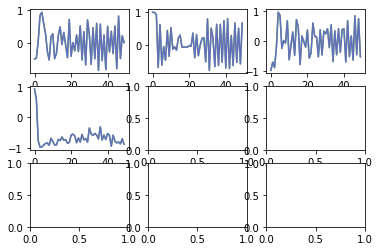

In [15]:
benchmark_policy(sac_policy, '/home/hendrik/Documents/master_project/LokalData/ImitationLearning/', 'benchmark SAC', eval_epochs=200, val_env=model.env, stepid=1, best_reward=-1, save_model=False)

In [ ]:
bc_trainer.train(n_epochs=100)

In [ ]:
#path_to_zip_file = '/home/hendrik/Documents/master_project/Code/rl-baselines3-zoo/rl-trained-agents/her/FetchPickAndPlace-v1_1/FetchPickAndPlace-v1.zip'
path_to_zip_file = '/home/hendrik/Documents/master_project/Code/rl-baselines3-zoo/logs/tqc/FetchPickAndPlace-v1_1/FetchPickAndPlace-v1.zip'
path_to_zip_file = '/home/hendrik/Documents/master_project/Code/rl-baselines3-zoo/rl-trained-agents/tqc/FetchPickAndPlace-v1_1/FetchPickAndPlace-v1.zip'
directory_to_extract_to = '/tmp/sbtest'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [ ]:
policy = torch.load('/tmp/sbtest/policy.pth')

In [ ]:
train_policy(
    trainer=model, 
    learn_fct=learn_wrapper.train, 
    val_env=val_env, 
    logname='HER Test', 
    path='/home/hendrik/Documents/master_project/LokalData/nISB/',
    n_epochs=1000,
    n_steps=20,
    eval_epochs=100)